In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

!kaggle datasets download -d arunrk7/surface-crack-detection
!unzip -q surface-crack-detection.zip



 99% 230M/233M [00:02<00:00, 80.3MB/s]
100% 233M/233M [00:02<00:00, 86.7MB/s]


In [ ]:
!kaggle datasets download -d keras/inceptionv3
!unzip -q inceptionv3.zip

inceptionv3.zip: Skipping, found more recently modified local copy (use --force to force download)
replace inception_v3_weights_tf_dim_ordering_tf_kernels.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [ ]:
!pip install opencv-python

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model,layers
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
        if len(images)>3:
            break
    fig=plt.figure(figsize=(10,12))
    xrange=range(1,5)
    
    for img,x in zip(images,xrange):
        ax=fig.add_subplot(2,2,x)
        ax.imshow(img)
        ax.set_title(img.shape)

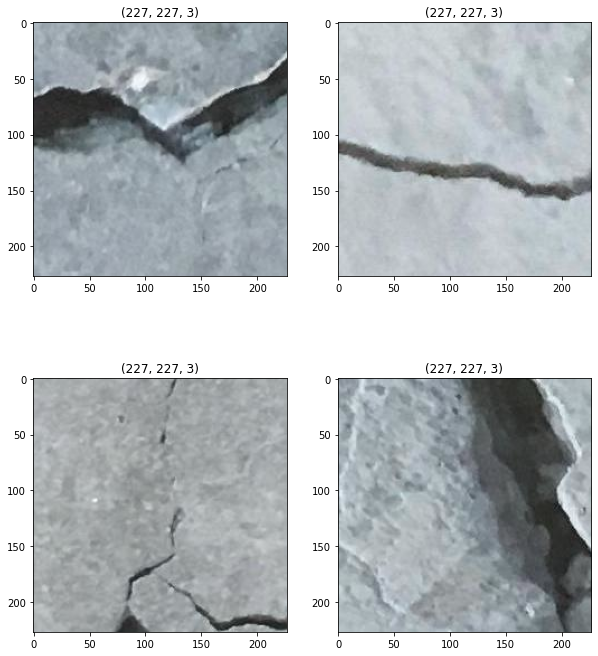

In [ ]:
load_images_from_folder("Positive")

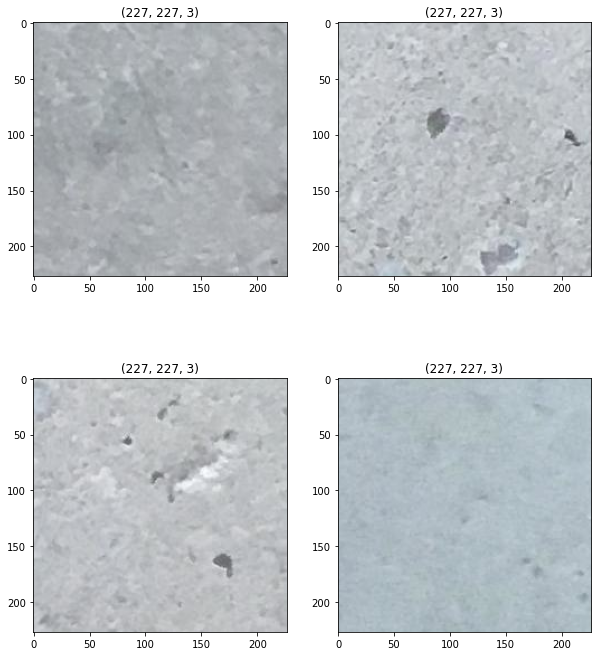

In [ ]:
load_images_from_folder("Negative")

In [ ]:
# You have to add Inception V3 files from 
# file--> add or upload data-->search by URL--> https://www.kaggle.com/keras/inceptionv3
!ls /kaggle/input

In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
     layer.trainable = False
        
# Print the model summary
# pre_trained_model.summary()

In [ ]:
# We will use the part of the pre_trained model from input later until the layer 'mixed7'
# You can also choose different layer for starting
last_layer = pre_trained_model.get_layer('mixed7') 
last_output = last_layer.output

#Then we add our layers 

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout layer to prevent overfitting
x = layers.Dropout(0.1)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x)
model.compile(optimizer = RMSprop(lr=0.01), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
    
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Create Data Generator
# Split data train-validation sets by using validation_split=0.3
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.4)

train_generator = train_datagen.flow_from_directory( '../content/crack', #'../input/surface-crack-detection'
                                                     target_size=(150,150),
                                                     batch_size=64,
                                                     shuffle=True,
                                                     class_mode='binary',
                                                     subset='training')        

Found 24000 images belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.5)

validation_generator =  validation_datagen.flow_from_directory('../content/crack', #'../input/surface-crack-detection'
                                                                target_size=(150,150),
                                                                batch_size=64,
                                                                class_mode='binary',
                                                                subset='validation')          
                                       

Found 20000 images belonging to 2 classes.


In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
callbacks = myCallback()

history = model.fit_generator(train_generator,
            validation_data = validation_generator,
            epochs = 7,
            verbose = 1,
            callbacks=[callbacks]) # early_stopping

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/7
375/375 [==============================] - 101s 176ms/step - loss: 46.5927 - accuracy: 0.9492 - val_loss: 1.9366 - val_accuracy: 0.9889
Epoch 2/7
375/375 [==============================] - 64s 172ms/step - loss: 1.9506 - accuracy: 0.9879 - val_loss: 1.4149 - val_accuracy: 0.9949
Epoch 3/7
375/375 [==============================] - 64s 172ms/step - loss: 1.4909 - accuracy: 0.9933 - val_loss: 0.6805 - val_accuracy: 0.9965
Epoch 4/7
375/375 [==============================] - 64s 171ms/step - loss: 1.1482 - accuracy: 0.9944 - val_loss: 0.6360 - val_accuracy: 0.9977
Epoch 5/7
375/375 [==============================] - 64s 171ms/step - loss: 1.0797 - accuracy: 0.9962 - val_loss: 0.8039 - val_accuracy: 0.9958
Epoch 6/7
375/375 [==============================] - 64s 170ms/step - loss: 0.2688 - accuracy: 0.9980 - val_loss: 0.9272 - val_accuracy: 0.9956
Epoch 7/7
375/375 [==============================] - 64s 169ms/step - loss: 0.4563 - accuracy: 0.9977 - val_loss: 3.7313 - val_accurac

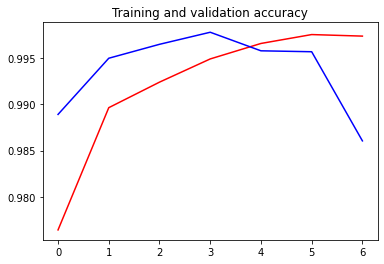

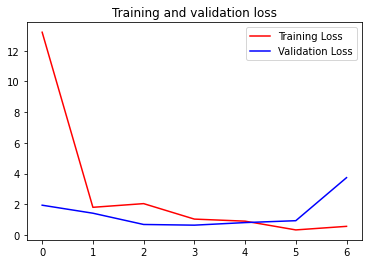

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

In [ ]:
!pwd

In [ ]:
model.save('Crack_Detection_InceptionV3_model_v1.h5')

In [ ]:
!ls /content

content
crack
Crack_Detection_InceptionV3_model_v1.h5
imagenet_class_index.json
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
inceptionv3.zip
sample_data
surface-crack-detection.zip


In [ ]:
# load model
#from keras.models import load_model

#model_inception = load_model('Crack_Detection_InceptionV3_model.h5')
# summarize model.
#model_inception.summary()